In [1]:
import sys
sys.path.append('/net/mulan/home/huiwann/spatial/SVC/')
import tifffile
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
from model.utils import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_path = '/net/mulan/home/huiwann/spatial/SVC/' 
dataset = 'data/merfish_U2OS' 

gene_names = []
cell_names = []

with open(f'{data_path}{dataset}/gene_names.txt', 'r') as file:
    for line in file:
        gene_names.append(line.strip())

with open(f'{data_path}{dataset}/cell_names.txt', 'r') as file:
    for line in file:
        cell_names.append(line.strip())

In [3]:
batch=('-61','-62','-63','-64','-65','-66','-67','-68')
train_indices,test_indices = [],[]
for i, s in enumerate(cell_names):
    if s.endswith(batch):
        test_indices.append(i)
    else:
        train_indices.append(i)
test_cell_names = np.array(cell_names)[test_indices]

In [4]:
prediction_all_genes_mu = np.load(f"{data_path}output/merfish_U2OS/prediction_all_genes_mu.npz")["prediction"]
prediction_all_genes_r = np.load(f"{data_path}output/merfish_U2OS/prediction_all_genes_r.npz")["prediction"]

In [5]:
select_gene = ['SLC5A3', 'SRRM2', 'COL5A1', 'USP9X', 'TLN1']

prediction_selected_genes_mu = prediction_all_genes_mu[:, [gene_names.index(gene) for gene in select_gene], :]
prediction_selected_genes_r = prediction_all_genes_r[:, [gene_names.index(gene) for gene in select_gene], :]

In [6]:
np.random.seed(2025)
count_data = np.zeros((prediction_selected_genes_mu.shape[0],prediction_selected_genes_mu.shape[1], 48, 48))
for i in tqdm(range(prediction_selected_genes_mu.shape[0])):
    for j in range(prediction_selected_genes_mu.shape[1]):

        cell_gene_mu = prediction_selected_genes_mu[i,j]
        cell_gene_r = prediction_selected_genes_r[i,j]
        cell_gene_mu = np.repeat(cell_gene_mu/4, 4, axis=0)
        cell_gene_mu = np.repeat(cell_gene_mu/4, 4, axis=1)
        
        cell_gene_r = np.repeat(cell_gene_r, 4, axis=1)
        cell_gene_r = np.repeat(cell_gene_r, 4, axis=0)
        mask = cell_gene_r > 0
        count_data_0 = np.zeros((48,48))
        n = cell_gene_r[mask]
        p = cell_gene_r[mask] / (cell_gene_r[mask] + cell_gene_mu[mask])
        count_data_0[mask] = np.random.negative_binomial(n, p)
        count_data[i,j] = count_data_0
print("shape of count_data:",count_data.shape)

100%|██████████| 122/122 [00:00<00:00, 1072.91it/s]

shape of count_data: (122, 5, 48, 48)


In [ ]:
non_zero_df_pred = pd.DataFrame()
for i in tqdm(select_gene):
    count_data_i = count_data[:,select_gene.index(i)]
    non_zero_indices = np.argwhere(count_data_i != 0)
    non_zero_values = count_data_i[non_zero_indices[:, 0],  non_zero_indices[:, 1], non_zero_indices[:, 2]]

    center_x, center_y = 24,24
    x, y = non_zero_indices[:, 2], non_zero_indices[:, 1]
    ratio = np.sqrt((x+0.5 - center_x) ** 2 + (y+0.5 - center_y) ** 2)/24
    ratio = np.minimum(ratio, 1)
    angles = (np.degrees(np.arctan2(y+0.5 - center_y, x+0.5 - center_x))*2).round()/2
    cell = np.array(test_cell_names)[non_zero_indices[:, 0]]
    gene = np.repeat(i, len(non_zero_values))
    count = non_zero_values.flatten()

    non_zero_df_pred_i = pd.DataFrame({
        'cell': cell,
        'gene': gene,
        'count': count,
        'x': x,
        'y': y,
        'ratio': ratio,
        'direction_vec': angles
    })

    non_zero_df_pred = pd.concat([non_zero_df_pred, non_zero_df_pred_i], axis=0)
print(non_zero_df_pred)


100%|██████████| 5/5 [00:00<00:00, 84.99it/s]

        cell    gene  count   x   y     ratio  direction_vec
0       2-61  SLC5A3    2.0  29   0  1.000000          -77.0
1       2-61  SLC5A3    1.0  16   3  0.909537         -110.0
2       2-61  SLC5A3    1.0  16   5  0.831769         -112.0
3       2-61  SLC5A3    1.0  20   8  0.662094         -102.5
4       2-61  SLC5A3    1.0  12   9  0.771115         -128.5
...      ...     ...    ...  ..  ..       ...            ...
51003  53-62    TLN1    2.0  18  47  1.000000          103.0
51004  53-62    TLN1    2.0  21  47  0.984692           96.0
51005  53-62    TLN1    5.0  22  47  0.981159           93.5
51006  53-62    TLN1    3.0  24  47  0.979388           89.0
51007  53-62    TLN1    1.0  28  47  0.996957           79.0

[178998 rows x 7 columns]


In [9]:
df_cell_contour = pd.read_pickle(f"{data_path}{dataset}/cell_mask_contour_preprocessed.pkl")
print(df_cell_contour)
df_nuclear_contour = pd.read_pickle(f"{data_path}{dataset}/nuclear_mask_contour_preprocessed.pkl")
print(df_nuclear_contour)

    cell       x      y      centerX     centerY  direction_vec  \
0   0-32   621.0   59.0   679.482759  163.641379         -119.0   
1   0-32   621.0   71.0   679.482759  163.641379         -122.5   
2   0-32   586.0   71.0   679.482759  163.641379         -135.5   
3   0-32   586.0   82.0   679.482759  163.641379         -139.0   
4   0-32   551.0   82.0   679.482759  163.641379         -147.5   
..   ...     ...    ...          ...         ...            ...   
48  9-68  1592.0  270.0  1444.358382  452.421965          -51.0   
49  9-68  1592.0  223.0  1444.358382  452.421965          -57.0   
50  9-68  1580.0  223.0  1444.358382  452.421965          -59.5   
51  9-68  1580.0  188.0  1444.358382  452.421965          -63.0   
52  9-68  1569.0  188.0  1444.358382  452.421965          -65.0   

    distance_to_center  
0           119.875149  
1           109.556644  
2           131.610985  
3           124.114226  
4           152.227245  
..                 ...  
48          234.6823

In [10]:
non_zero_df_pred['centerX'] = 0
non_zero_df_pred['centerY'] = 0
for cell in tqdm(non_zero_df_pred.cell.unique()):
    cell_center_x = df_cell_contour.centerX[df_cell_contour.cell == cell].values[0]
    cell_center_y = df_cell_contour.centerY[df_cell_contour.cell == cell].values[0]

    non_zero_df_pred.loc[non_zero_df_pred.cell == cell,'centerX'] = cell_center_x
    non_zero_df_pred.loc[non_zero_df_pred.cell == cell,'centerY'] = cell_center_y
print(non_zero_df_pred)    

  0%|          | 0/122 [00:00<?, ?it/s]

100%|██████████| 122/122 [00:02<00:00, 41.64it/s]

        cell    gene  count   x   y     ratio  direction_vec      centerX  \
0       2-61  SLC5A3    2.0  29   0  1.000000          -77.0  1715.372881   
1       2-61  SLC5A3    1.0  16   3  0.909537         -110.0  1715.372881   
2       2-61  SLC5A3    1.0  16   5  0.831769         -112.0  1715.372881   
3       2-61  SLC5A3    1.0  20   8  0.662094         -102.5  1715.372881   
4       2-61  SLC5A3    1.0  12   9  0.771115         -128.5  1715.372881   
...      ...     ...    ...  ..  ..       ...            ...          ...   
51003  53-62    TLN1    2.0  18  47  1.000000          103.0   604.207254   
51004  53-62    TLN1    2.0  21  47  0.984692           96.0   604.207254   
51005  53-62    TLN1    5.0  22  47  0.981159           93.5   604.207254   
51006  53-62    TLN1    3.0  24  47  0.979388           89.0   604.207254   
51007  53-62    TLN1    1.0  28  47  0.996957           79.0   604.207254   

           centerY  
0       206.949153  
1       206.949153  
2       206.

In [11]:
non_zero_df_pred['distance_to_center'] = 0
i = 0
for cell in tqdm(non_zero_df_pred.cell.unique()):
    non_zero_df_pred.loc[non_zero_df_pred.cell==cell,'distance_to_center'] = find_closest_point(non_zero_df_pred[non_zero_df_pred.cell==cell], df_cell_contour[df_cell_contour.cell==cell], 'direction_vec', 'cell')
print(non_zero_df_pred.head())

100%|██████████| 122/122 [00:27<00:00,  4.40it/s]

   cell    gene  count   x  y     ratio  direction_vec      centerX  \
0  2-61  SLC5A3    2.0  29  0  1.000000          -77.0  1715.372881   
1  2-61  SLC5A3    1.0  16  3  0.909537         -110.0  1715.372881   
2  2-61  SLC5A3    1.0  16  5  0.831769         -112.0  1715.372881   
3  2-61  SLC5A3    1.0  20  8  0.662094         -102.5  1715.372881   
4  2-61  SLC5A3    1.0  12  9  0.771115         -128.5  1715.372881   

      centerY  distance_to_center  
0  206.949153          205.069701  
1  206.949153          209.837106  
2  206.949153          191.895592  
3  206.949153          152.750108  
4  206.949153          180.670428  


In [12]:
non_zero_df_pred['angle_radians'] = non_zero_df_pred['direction_vec'].apply(lambda x: np.radians(x))
non_zero_df_pred['x_original'] = non_zero_df_pred.apply(lambda row: row['distance_to_center'] * np.cos(row['angle_radians']) + row['centerX'], axis=1)
non_zero_df_pred['y_original'] = non_zero_df_pred.apply(lambda row: row['distance_to_center'] * np.sin(row['angle_radians']) + row['centerY'], axis=1)
print(non_zero_df_pred.head())

   cell    gene  count   x  y     ratio  direction_vec      centerX  \
0  2-61  SLC5A3    2.0  29  0  1.000000          -77.0  1715.372881   
1  2-61  SLC5A3    1.0  16  3  0.909537         -110.0  1715.372881   
2  2-61  SLC5A3    1.0  16  5  0.831769         -112.0  1715.372881   
3  2-61  SLC5A3    1.0  20  8  0.662094         -102.5  1715.372881   
4  2-61  SLC5A3    1.0  12  9  0.771115         -128.5  1715.372881   

      centerY  distance_to_center  angle_radians   x_original  y_original  
0  206.949153          205.069701      -1.343904  1761.503527    7.135375  
1  206.949153          209.837106      -1.919862  1643.604364    9.766772  
2  206.949153          191.895592      -1.954769  1643.487527   29.026658  
3  206.949153          152.750108      -1.788962  1682.311707   57.819832  
4  206.949153          180.670428      -2.242748  1602.902895   65.555002  


In [13]:
non_zero_df_pred.to_csv(f"{data_path}output/merfish_U2OS/prediction_count_data_5_genes.csv")

In [14]:
non_zero_df_pred = pd.read_csv(f"{data_path}output/merfish_U2OS/prediction_count_data_5_genes.csv")

In [15]:
merfish_U2OS_data = pd.read_csv(f"{data_path}/{dataset}/merfish_U2OS_transcripts.gz")
print(merfish_U2OS_data)

          Unnamed: 0           x            y    gene   cell  nucleus  batch  \
0                  4  1541.75090   124.650345  AKAP11   11-0       -1      0   
1                  5  1526.97580   248.519300  AKAP11   11-0       -1      0   
2                  6  1739.53400   363.478000  AKAP11   11-0        3      0   
3                  7  1420.07250   542.724060  AKAP11   16-0        7      0   
4                  8  1452.24240   563.947270  AKAP11   16-0        7      0   
...              ...         ...          ...     ...    ...      ...    ...   
13788203    16907938  1465.14840  1417.416300  PLXNA1  33-69       15     69   
13788204    16907939   470.02463   726.523130   PRKCA  16-69        8     69   
13788205    16907940   504.41980   737.000000   PRKCA  16-69        8     69   
13788206    16907941   399.72684   700.080570   LUZP1  16-69        8     69   
13788207    16907947   500.70080   673.430700    FBN2  16-69        8     69   

              centerX      centerY  dis

In [ ]:
from matplotlib.path import Path
def draw_close_point(points):
    center = np.mean(points, axis=0)
    angles = np.arctan2(points[:, 1] - center[1], points[:, 0] - center[0])

    sorted_indices = np.argsort(angles)
    sorted_points = points[sorted_indices]
    closed_points = np.vstack([sorted_points, sorted_points[0]])
    return closed_points

def _ensure_closed(poly):
    poly = np.asarray(poly, float)
    if not np.allclose(poly[0], poly[-1]):
        poly = np.vstack([poly, poly[0]])
    return poly

def _project_point_to_segment(p, a, b):
    ab = b - a
    denom = float(np.dot(ab, ab))
    if denom == 0.0:
        return a.copy()
    t = float(np.dot(p - a, ab)) / denom
    t = 0.0 if t < 0.0 else (1.0 if t > 1.0 else t)
    return a + t * ab

def _closest_point_on_boundary(p, poly_closed):
    best_q = None
    best_d2 = np.inf
    for i in range(poly_closed.shape[0] - 1):
        a = poly_closed[i]
        b = poly_closed[i + 1]
        q = _project_point_to_segment(p, a, b)
        d2 = float(np.dot(p - q, p - q))
        if d2 < best_d2:
            best_d2 = d2
            best_q = q
    return best_q

def clip_points_into_cell(scatter_points, closed_points_cell, include_boundary=True):
    poly = _ensure_closed(closed_points_cell)
    path = Path(poly)

    pts = np.asarray(scatter_points, float)
    out = pts.copy()

    for k, p in enumerate(pts):
        inside = path.contains_point(p, radius=0.0)
        if include_boundary and (not inside):
            inside = path.contains_point(p, radius=1e-9)

        if inside:
            continue

        out[k] = _closest_point_on_boundary(p, poly)

    return out


In [17]:
batch='64'
preserve_idx_merfish_U2OS_data =[]
for i in merfish_U2OS_data.cell:
    if i.split('-')[1] == batch:
        preserve_idx_merfish_U2OS_data.append(True)
    else:
        preserve_idx_merfish_U2OS_data.append(False)
        
preserve_idx_merfish_U2OS_data = np.array(preserve_idx_merfish_U2OS_data)

preserve_idx_predict_data =[]
for i in non_zero_df_pred.cell:
    if i.split('-')[1] == batch:
        preserve_idx_predict_data.append(True)
    else:
        preserve_idx_predict_data.append(False)

preserve_idx_predict_data = np.array(preserve_idx_predict_data)


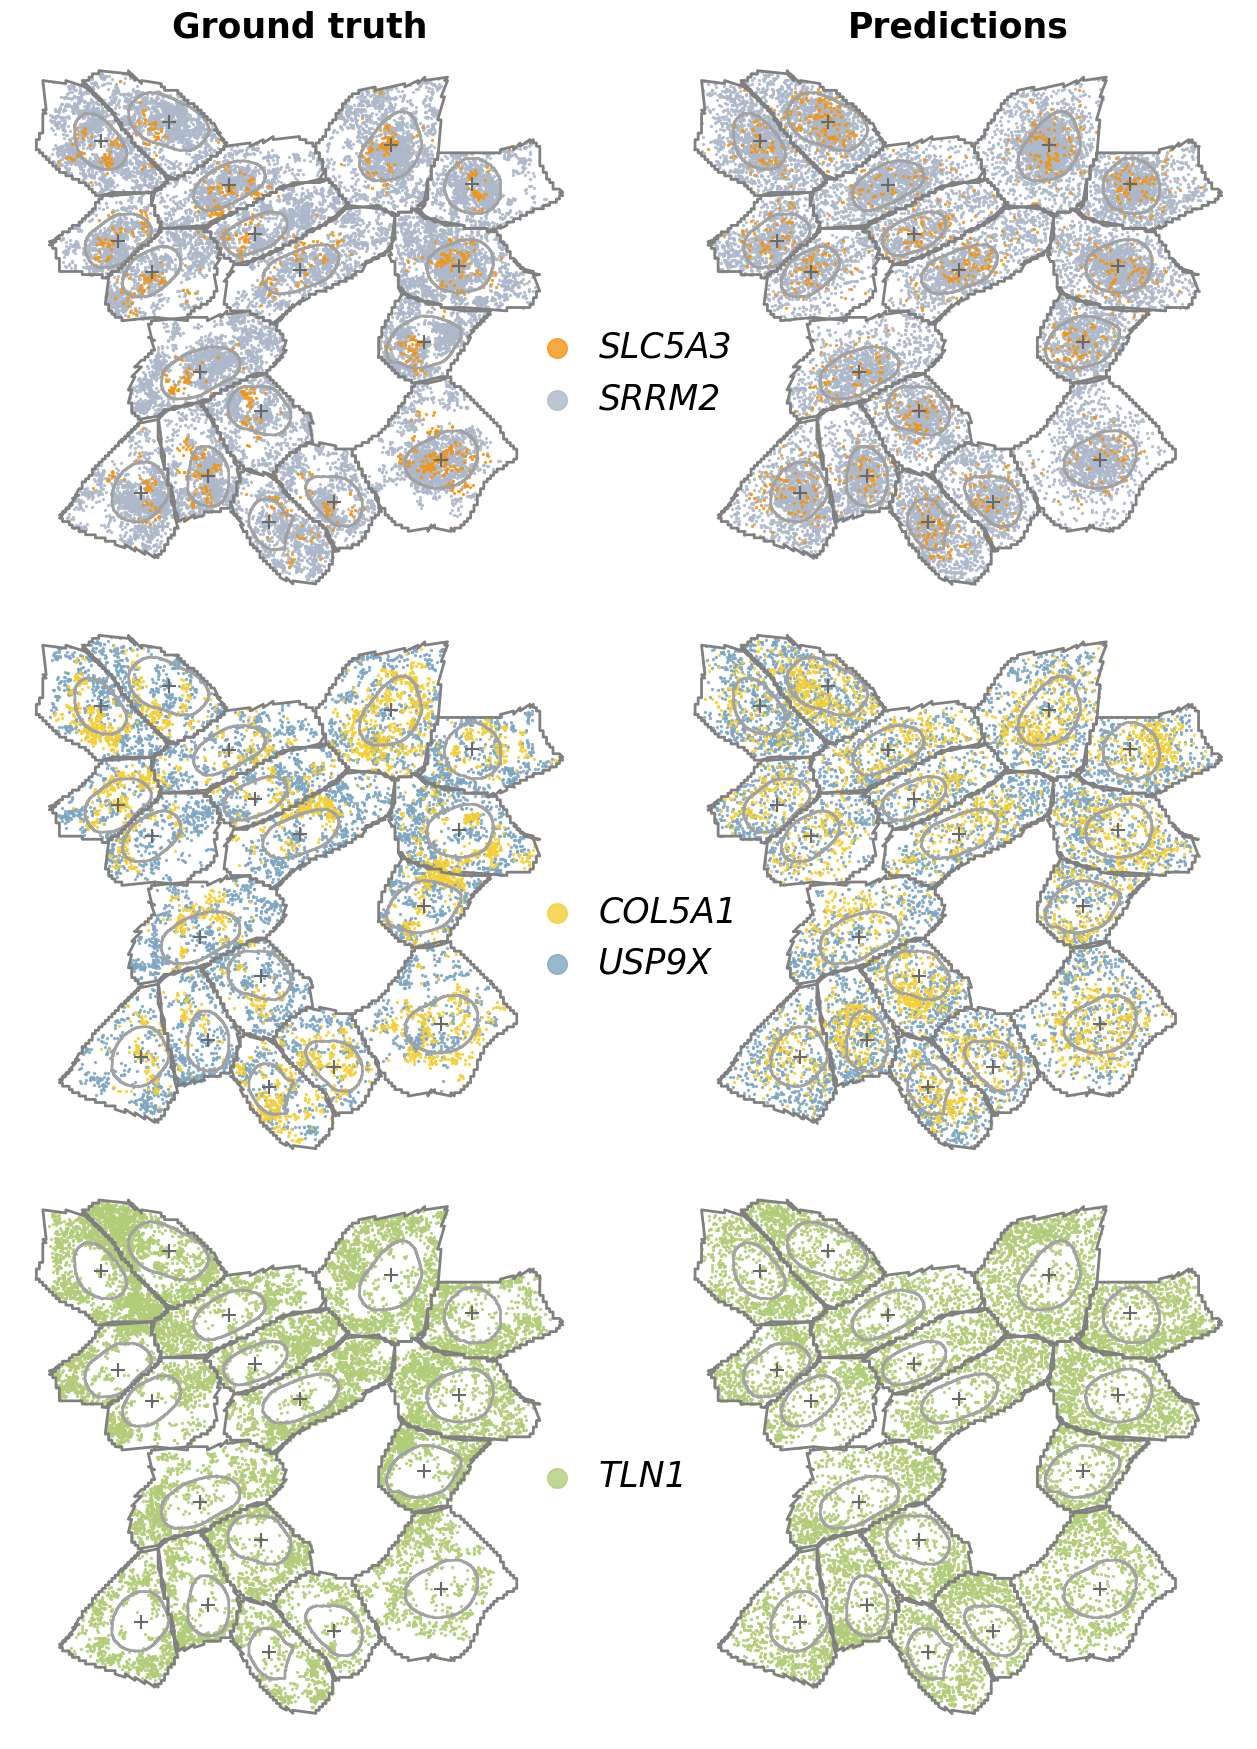

In [18]:
from matplotlib.font_manager import FontProperties
fig, ax = plt.subplots(3, 2, figsize=(17, 22), gridspec_kw={'hspace': 0., 'wspace': 0} )
gene1 = 'SLC5A3'
gene2 = 'SRRM2'
gene3 = 'COL5A1'
gene4 = 'USP9X'
gene5 = 'TLN1'
colors = ["#f49512","#ADB9CA","#f5cf36","#7EA6C2","#B2CD79"]
non_zero_df_pred_i = non_zero_df_pred[preserve_idx_predict_data] 
non_zero_df_pred_exploded_i = non_zero_df_pred_i.loc[non_zero_df_pred_i.index.repeat(non_zero_df_pred_i['count'])].reset_index(drop=True)
truth_i = merfish_U2OS_data[preserve_idx_merfish_U2OS_data]
k = 0
cell_ids = [i for i in df_cell_contour.cell.unique() if i.endswith(f'-{batch}')]
for cell_id in cell_ids:
    non_zero_df_pred_exploded_i_cell = non_zero_df_pred_exploded_i[non_zero_df_pred_exploded_i['cell']==cell_id]
    transcript_filtered_gene1 = non_zero_df_pred_exploded_i_cell[non_zero_df_pred_exploded_i_cell['gene']==gene1]
    transcript_filtered_gene2 = non_zero_df_pred_exploded_i_cell[non_zero_df_pred_exploded_i_cell['gene']==gene2]
    transcript_filtered_gene3 = non_zero_df_pred_exploded_i_cell[non_zero_df_pred_exploded_i_cell['gene']==gene3]
    transcript_filtered_gene4 = non_zero_df_pred_exploded_i_cell[non_zero_df_pred_exploded_i_cell['gene']==gene4]
    transcript_filtered_gene5 = non_zero_df_pred_exploded_i_cell[non_zero_df_pred_exploded_i_cell['gene']==gene5]
    transcript_filtered_gene1_x, transcript_filtered_gene1_y = transcript_filtered_gene1.x_original+np.random.normal(0, 10, size=transcript_filtered_gene1.x_original.shape), transcript_filtered_gene1.y_original+np.random.normal(0, 10, size=transcript_filtered_gene1.y_original.shape)
    transcript_filtered_gene2_x, transcript_filtered_gene2_y = transcript_filtered_gene2.x_original+np.random.normal(0, 10, size=transcript_filtered_gene2.x_original.shape), transcript_filtered_gene2.y_original+np.random.normal(0, 10, size=transcript_filtered_gene2.y_original.shape)
    transcript_filtered_gene3_x, transcript_filtered_gene3_y = transcript_filtered_gene3.x_original+np.random.normal(0, 10, size=transcript_filtered_gene3.x_original.shape), transcript_filtered_gene3.y_original+np.random.normal(0, 10, size=transcript_filtered_gene3.y_original.shape)
    transcript_filtered_gene4_x, transcript_filtered_gene4_y = transcript_filtered_gene4.x_original+np.random.normal(0, 10, size=transcript_filtered_gene4.x_original.shape), transcript_filtered_gene4.y_original+np.random.normal(0, 10, size=transcript_filtered_gene4.y_original.shape)
    transcript_filtered_gene5_x, transcript_filtered_gene5_y = transcript_filtered_gene5.x_original+np.random.normal(0, 10, size=transcript_filtered_gene5.x_original.shape), transcript_filtered_gene5.y_original+np.random.normal(0, 10, size=transcript_filtered_gene5.y_original.shape)

    truth_i_cell = truth_i[truth_i['cell']==cell_id]
    truth_i_gene1 = truth_i_cell[truth_i_cell['gene']==gene1]
    truth_i_gene2 = truth_i_cell[truth_i_cell['gene']==gene2]
    truth_i_gene3 = truth_i_cell[truth_i_cell['gene']==gene3]
    truth_i_gene4 = truth_i_cell[truth_i_cell['gene']==gene4]
    truth_i_gene5 = truth_i_cell[truth_i_cell['gene']==gene5]
    truth_i_gene1_x, truth_i_gene1_y = truth_i_gene1.x+np.random.normal(0, 10, size=truth_i_gene1.y.shape), truth_i_gene1.y+np.random.normal(0, 10, size=truth_i_gene1.y.shape)
    truth_i_gene2_x, truth_i_gene2_y = truth_i_gene2.x+np.random.normal(0, 10, size=truth_i_gene2.y.shape), truth_i_gene2.y+np.random.normal(0, 10, size=truth_i_gene2.y.shape) 
    truth_i_gene3_x, truth_i_gene3_y = truth_i_gene3.x+np.random.normal(0, 10, size=truth_i_gene3.y.shape), truth_i_gene3.y+np.random.normal(0, 10, size=truth_i_gene3.y.shape)
    truth_i_gene4_x, truth_i_gene4_y = truth_i_gene4.x+np.random.normal(0, 10, size=truth_i_gene4.y.shape), truth_i_gene4.y+np.random.normal(0, 10, size=truth_i_gene4.y.shape)
    truth_i_gene5_x, truth_i_gene5_y = truth_i_gene5.x+np.random.normal(0, 10, size=truth_i_gene5.y.shape), truth_i_gene5.y+np.random.normal(0, 10, size=truth_i_gene5.y.shape)
    
    cell_mask_contour_i= df_cell_contour[(df_cell_contour.cell == cell_id)]
    closed_points_cell = draw_close_point(cell_mask_contour_i[['x', 'y']].values)
    nuclear_mask_contour_i = df_nuclear_contour[(df_nuclear_contour.cell == cell_id)]
    closed_points_nuclear = draw_close_point(nuclear_mask_contour_i[['x', 'y']].values)

    truth_i_scatter_points_gene1 = np.column_stack((truth_i_gene1_x, truth_i_gene1_y))
    truth_i_scatter_points_gene1 = clip_points_into_cell(truth_i_scatter_points_gene1, closed_points_cell)
    truth_i_scatter_points_gene2 = np.column_stack((truth_i_gene2_x, truth_i_gene2_y))
    truth_i_scatter_points_gene2 = clip_points_into_cell(truth_i_scatter_points_gene2, closed_points_cell)
    truth_i_scatter_points_gene3 = np.column_stack((truth_i_gene3_x, truth_i_gene3_y))
    truth_i_scatter_points_gene3 = clip_points_into_cell(truth_i_scatter_points_gene3, closed_points_cell)
    truth_i_scatter_points_gene4 = np.column_stack((truth_i_gene4_x, truth_i_gene4_y))
    truth_i_scatter_points_gene4 = clip_points_into_cell(truth_i_scatter_points_gene4, closed_points_cell)
    truth_i_scatter_points_gene5 = np.column_stack((truth_i_gene5_x, truth_i_gene5_y))
    truth_i_scatter_points_gene5 = clip_points_into_cell(truth_i_scatter_points_gene5, closed_points_cell)

    pred_i_scatter_points_gene1 = np.column_stack((transcript_filtered_gene1_x, transcript_filtered_gene1_y))
    pred_i_scatter_points_gene1 = clip_points_into_cell(pred_i_scatter_points_gene1, closed_points_cell)
    pred_i_scatter_points_gene2 = np.column_stack((transcript_filtered_gene2_x, transcript_filtered_gene2_y))
    pred_i_scatter_points_gene2 = clip_points_into_cell(pred_i_scatter_points_gene2, closed_points_cell)
    pred_i_scatter_points_gene3 = np.column_stack((transcript_filtered_gene3_x, transcript_filtered_gene3_y))
    pred_i_scatter_points_gene3 = clip_points_into_cell(pred_i_scatter_points_gene3, closed_points_cell)
    pred_i_scatter_points_gene4 = np.column_stack((transcript_filtered_gene4_x, transcript_filtered_gene4_y))
    pred_i_scatter_points_gene4 = clip_points_into_cell(pred_i_scatter_points_gene4, closed_points_cell)
    pred_i_scatter_points_gene5 = np.column_stack((transcript_filtered_gene5_x, transcript_filtered_gene5_y))
    pred_i_scatter_points_gene5 = clip_points_into_cell(pred_i_scatter_points_gene5, closed_points_cell)
    fp = FontProperties(style='italic',size=25)
    ax[0,0].scatter(truth_i_scatter_points_gene1[:, 0], truth_i_scatter_points_gene1[:, 1], s=2, color = colors[0], label=gene1,zorder=25, alpha=0.8)        
    ax[0,0].scatter(truth_i_scatter_points_gene2[:, 0], truth_i_scatter_points_gene2[:, 1], s=2, color = colors[1], label=gene2,zorder=20, alpha=0.8)                
    ax[0,0].set_aspect('equal') 
    ax[0,0].set_title(f'Ground truth', fontsize=25, fontweight='bold') 
    if k == 0:
        ax[0,0].legend(markerscale=10, bbox_to_anchor=(0.83, 0.55),frameon=False, prop=fp, handletextpad=0.2) 

    ax[0,1].scatter(pred_i_scatter_points_gene1[:, 0], pred_i_scatter_points_gene1[:, 1], s=2, color = colors[0], label=gene1,zorder=25, alpha=0.8)             
    ax[0,1].scatter(pred_i_scatter_points_gene2[:, 0], pred_i_scatter_points_gene2[:, 1], s=2, color = colors[1], label=gene2,zorder=20, alpha=0.8)                    
    ax[0,1].set_aspect('equal')      
    ax[0,1].set_title(f'Predictions', fontsize=25, fontweight='bold')


    ax[1,0].scatter(truth_i_scatter_points_gene3[:, 0], truth_i_scatter_points_gene3[:, 1], s=2, color = colors[2], label=gene3, zorder=30, alpha=0.8)   
    ax[1,0].scatter(truth_i_scatter_points_gene4[:, 0], truth_i_scatter_points_gene4[:, 1], s=2, color = colors[3], label=gene4, zorder=25, alpha=0.8)   
    ax[1,0].set_aspect('equal')
    if k == 0:
        ax[1,0].legend(markerscale=10, bbox_to_anchor=(0.83, 0.55),frameon=False, prop=fp, handletextpad=0.2) 

    ax[1,1].scatter(pred_i_scatter_points_gene3[:, 0], pred_i_scatter_points_gene3[:, 1], s=2, color = colors[2], label=gene3, zorder=30, alpha=0.8)   
    ax[1,1].scatter(pred_i_scatter_points_gene4[:, 0], pred_i_scatter_points_gene4[:, 1], s=2, color = colors[3], label=gene4, zorder=25, alpha=0.8)
    ax[1,1].set_aspect('equal')

    ax[2,0].scatter(truth_i_scatter_points_gene5[:, 0], truth_i_scatter_points_gene5[:, 1], s=2, color = colors[4], label=gene5, zorder=20, alpha=0.8) 
    if k == 0:
        ax[2,0].legend(markerscale=10, bbox_to_anchor=(0.83, 0.55),frameon=False, prop=fp, handletextpad=0.2) 
    ax[2,1].scatter(pred_i_scatter_points_gene5[:, 0], pred_i_scatter_points_gene5[:, 1], s=2, color = colors[4], label=gene5, zorder=20, alpha=0.8)
    
    for i in range(3):
        for j in range(2):
            ax[i,j].plot(closed_points_nuclear[:, 0], closed_points_nuclear[:, 1], color='#A2A2A2',linewidth=2, zorder=30)
            ax[i,j].plot(closed_points_cell[:, 0], closed_points_cell[:, 1], color='grey',linewidth=2, zorder=30)
            ax[i,j].scatter(cell_mask_contour_i['centerX'][0], cell_mask_contour_i['centerY'][0], marker='+', color='dimgray', s=100, zorder=30)
            x = float(cell_mask_contour_i["centerX"][0]) 
            y = float(cell_mask_contour_i["centerY"][0])
            # ax[i, j].annotate(str(cell_id),(x, y),zorder=31)
            ax[i,j].axis('off')
            ax[i,j].set_aspect('equal', adjustable='box')
    k += 1

        
plt.show()